# Project Setu: Pincode Heatmaps & Risk Profiling
## UIDAI Data Hackathon 2026 - Official Submission

### 1. Introduction

This notebook, **Notebook 02**, focuses on the spatial analysis of Aadhaar update demand. By identifying geographic surge zones and high-load pincodes, UIDAI can transition from reactive queue management to proactive service orchestration.

#### Objectives
- **Visualize Demand Intensity**: Create heatmaps to show where MBU demand is concentrated.
- **Identify Surge Zones**: Pinpoint areas with rapid growth in update requirements.
- **Resource Optimization**: Provide data-driven insights for mobile van and camp deployment.

#### Data Privacy & Ethics
> **MANDATORY DISCLOSURE:**
> - This analysis uses **anonymized and aggregated** data only.
> - No individual Aadhaar numbers or personally identifiable information (PII) are present.
> - Geographic analysis is limited to the **pincode level** to ensure privacy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

### 2. Load & Merge Data

We load the biometric and demographic datasets to understand the total update pressure per pincode.

In [2]:
def load_and_concat(pattern):
    files = glob.glob(pattern)
    df_list = [pd.read_csv(f) for f in files]
    return pd.concat(df_list, ignore_index=True)

base_path = '/home/ubuntu/project_setu_data/data/'

df_bio = load_and_concat(os.path.join(base_path, 'biometric/*.csv'))
df_demo = load_and_concat(os.path.join(base_path, 'demographic/*.csv'))

df_bio['date'] = pd.to_datetime(df_bio['date'], dayfirst=True)
df_demo['date'] = pd.to_datetime(df_demo['date'], dayfirst=True)

print("Data loaded successfully.")

Data loaded successfully.


### 3. Aggregate Demand by Pincode

We calculate the total MBU demand (`bio_age_5_17`) and demographic update demand for each pincode.

In [3]:
# Aggregate Biometric Demand
pincode_bio = df_bio.groupby(['pincode', 'state', 'district'])['bio_age_5_17'].sum().reset_index()

# Aggregate Demographic Demand
pincode_demo = df_demo.groupby('pincode')['demo_age_5_17'].sum().reset_index()

# Merge
pincode_risk = pd.merge(pincode_bio, pincode_demo, on='pincode', how='left').fillna(0)
pincode_risk['total_update_load'] = pincode_risk['bio_age_5_17'] + pincode_risk['demo_age_5_17']

pincode_risk = pincode_risk.sort_values('total_update_load', ascending=False)
pincode_risk.head(10)

,pincode,state,district,bio_age_5_17,demo_age_5_17,total_update_load
3692,244001,Uttar Pradesh,Moradabad,45239,8255.0,53494.0
114,110094,Delhi,North East Delhi,30880,18284.0,49164.0
2247,202001,Uttar Pradesh,Aligarh,37196,6009.0,43205.0
4883,283203,Uttar Pradesh,Firozabad,35859,6753.0,42612.0
3945,247001,Uttar Pradesh,Saharanpur,31809,6098.0,37907.0
73,110059,Delhi,West Delhi,24328,11402.0,35730.0
100,110086,Delhi,North West Delhi,26574,7494.0,34068.0
10248,457001,Madhya Pradesh,Ratlam,28780,4731.0,33511.0
3761,244901,Uttar Pradesh,Rampur,27350,5784.0,33134.0
11095,486886,Madhya Pradesh,Singrauli,28142,4647.0,32789.0


### 4. Identifying High-Load & Surge Zones

We define "High-Load" pincodes as those in the top 5% of total update volume. These areas are candidates for permanent Aadhaar Seva Kendras (ASKs) or frequent mobile van visits.

In [4]:
threshold = pincode_risk['total_update_load'].quantile(0.95)
pincode_risk['risk_category'] = np.where(pincode_risk['total_update_load'] >= threshold, 'High Load', 'Normal')

print(f"High Load Threshold: {threshold:.2f} updates")
print(f"Number of High Load Pincodes: {len(pincode_risk[pincode_risk['risk_category'] == 'High Load'])}")

High Load Threshold: 5061.00 updates
Number of High Load Pincodes: 1568


### 5. Visualization: Demand Heatmap (Top Districts)

Since we are working with pincode data, we visualize the demand distribution across the top 15 districts to identify regional clusters.

/tmp/ipykernel_2752/1195480683.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='total_update_load', y='district', estimator=sum, errorbar=None, palette='viridis')


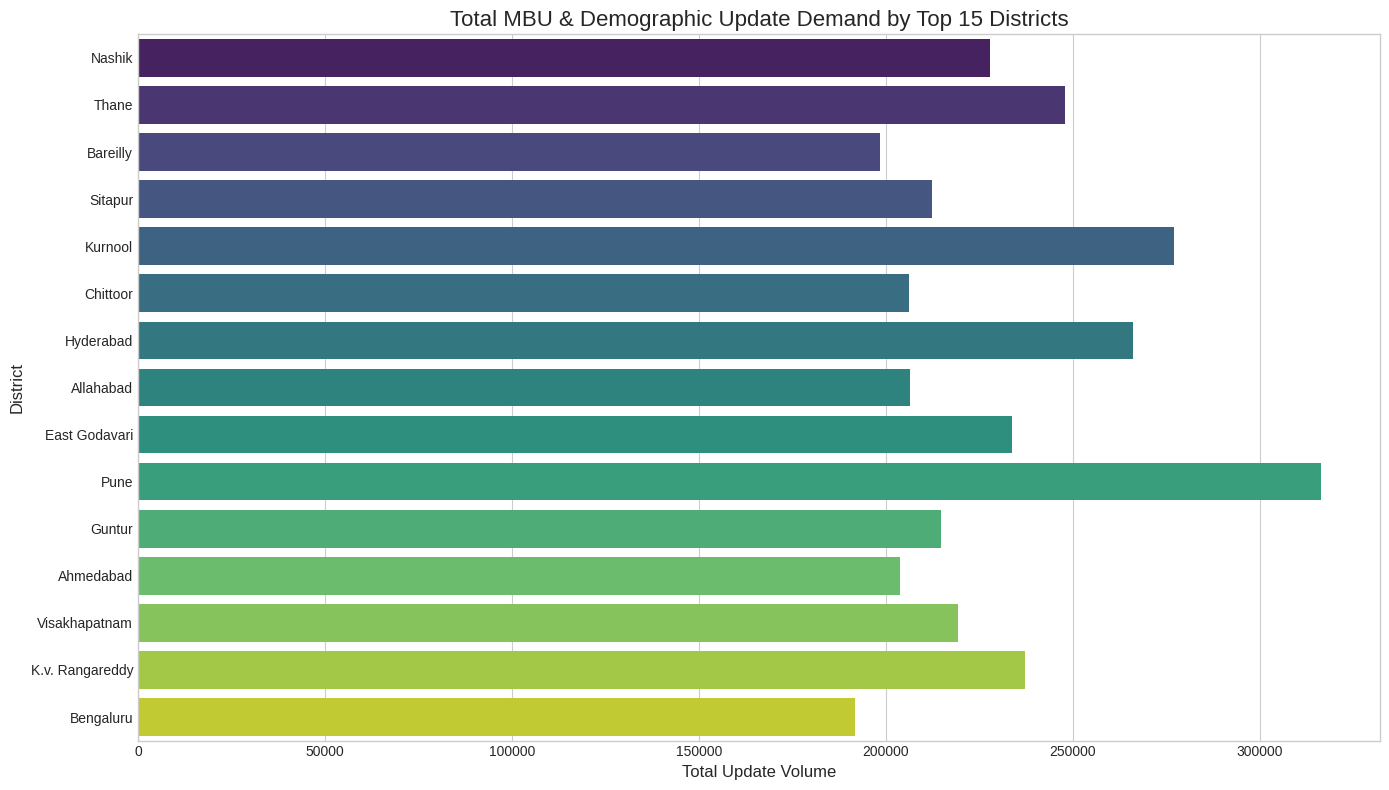

In [5]:
top_districts = pincode_risk.groupby('district')['total_update_load'].sum().nlargest(15).index
df_plot = pincode_risk[pincode_risk['district'].isin(top_districts)]

plt.figure(figsize=(14, 8))
sns.barplot(data=df_plot, x='total_update_load', y='district', estimator=sum, errorbar=None, palette='viridis')
plt.title('Total MBU & Demographic Update Demand by Top 15 Districts', fontsize=16)
plt.xlabel('Total Update Volume', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.show()

### 6. Pincode-Level Distribution

We use a boxplot to understand the variance of demand within the high-load districts.

/tmp/ipykernel_2752/864348939.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='total_update_load', y='district', palette='magma')


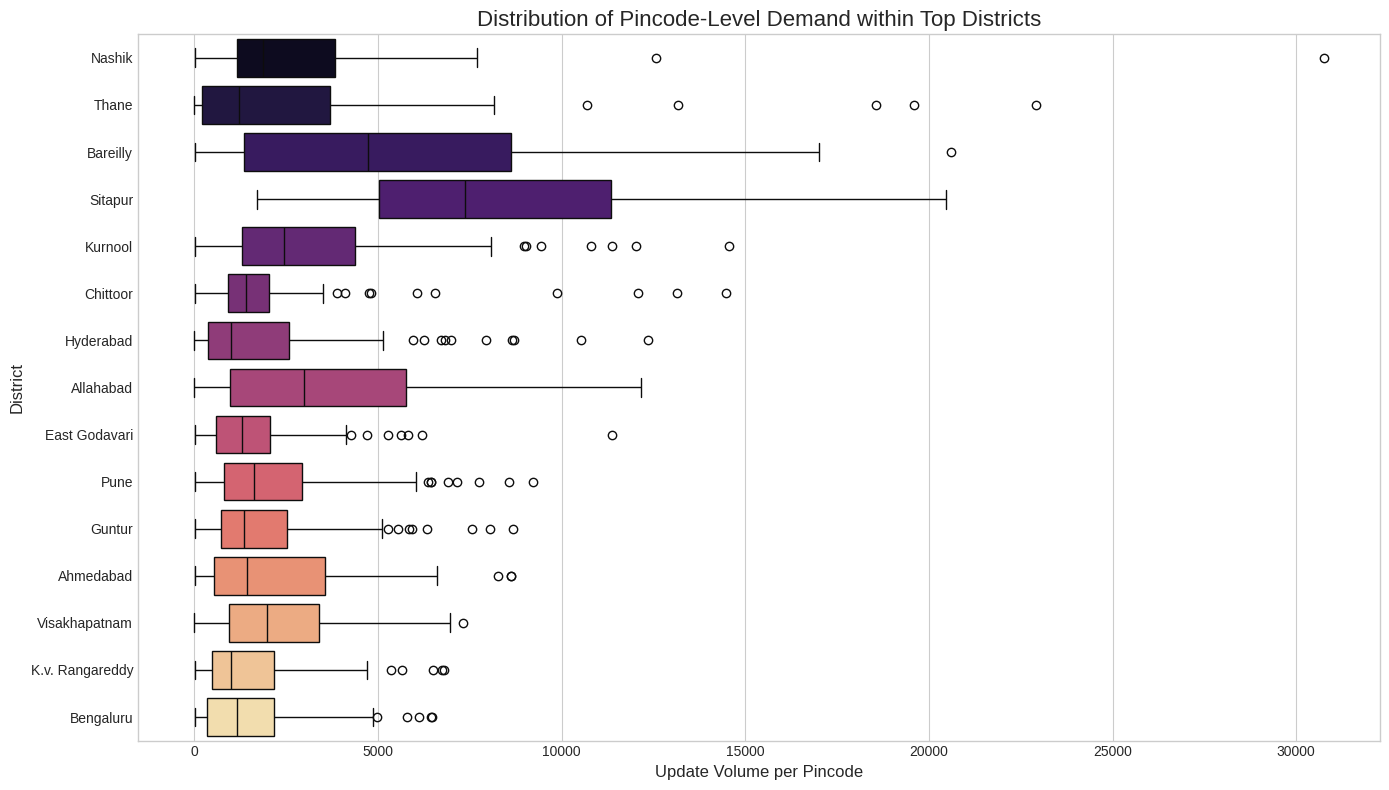

In [6]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_plot, x='total_update_load', y='district', palette='magma')
plt.title('Distribution of Pincode-Level Demand within Top Districts', fontsize=16)
plt.xlabel('Update Volume per Pincode', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.show()

### 7. Interpretation & Planning

#### Key Findings
- **Concentrated Demand**: A small percentage of pincodes account for a significant portion of the total update load.
- **Regional Clusters**: Certain districts show consistently high demand across all their pincodes, suggesting a need for regional hub-and-spoke service models.

#### UIDAI Actionable Insights
1. **Mobile Camp Scheduling**: Prioritize the "High Load" pincodes identified in Section 4 for the next quarter's mobile camp calendar.
2. **Infrastructure Augmentation**: Districts with high median demand (from the boxplot) should be evaluated for additional permanent Aadhaar Seva Kendras.
3. **Targeted Awareness**: Use the pincode list to send localized SMS nudges to residents in high-demand areas, encouraging them to book appointments in advance to avoid congestion.

---
*Project Setu: Bridging the gap between data and service delivery.*